In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV


from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score


Begin by reading in the data, then I will optimise for best C value using $L1$ Regression. Before doing this, I will split the data into test and train, and make a copy of the train set before downsampling the majority class. I will train two logistic regressions on each dataset and compare the results. I am using the vectorisation with 1 and 2-grams

In [3]:
df = pd.read_pickle("../data/reviews_vector_ngrams.pkl")

In [4]:
df[:10].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Columns: 504 entries, overall to your
dtypes: float64(501), int64(2), object(1)
memory usage: 39.5+ KB


In [5]:
df.duplicated().sum()

0

In [6]:
# Splitting the main data
X=df[df.columns[4:]]
y=df["binary"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [64]:
X.duplicated().sum()

92588

In [8]:
y_train.value_counts(normalize=True)

binary
1    0.760141
0    0.239859
Name: proportion, dtype: float64

In [37]:
# function for downsampling X_train
def downsample_binary(y_t, x_t, min = 0, maj=1):
    # combine x and y
    data = pd.concat([y_t, x_t], axis=1)
    target_name = data.columns[0]
    
    # count the instances of the minority class
    minority_count = data[data[target_name] == min].shape[0]
    
    # random sample from the majority class
    majority_sample = data[data[target_name] == maj].sample(n=minority_count, random_state=42)
    
    # merge together
    balanced_df = pd.concat([data[data[target_name] == min], majority_sample])
    
    # Shuffle
    balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    return balanced_df

balanced_set = downsample_binary(y_train, X_train)

In [38]:
# balanced class training sets
X_train_prime = balanced_set.drop("binary", axis=1)
y_train_prime = balanced_set["binary"]


In [7]:
# checking that the downsample worked
y_train.value_counts(), y_train_prime.value_counts()

(binary
 1    563854
 0    148501
 Name: count, dtype: int64,
 binary
 1    148501
 0    148501
 Name: count, dtype: int64)

Now we can scale the data for evaluation and then train a pipeline to find the best $C$ value.

In [44]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_transformed = scaler.transform(X_train)
X_test_transformed = scaler.transform(X_test)

In [45]:
scaler_prime = StandardScaler()
scaler_prime.fit(X_train_prime)
X_train_transformed_prime = scaler_prime.transform(X_train_prime)
X_test_transformed_prime = scaler_prime.transform(X_test)

In [ ]:
# testing for C value
penalties = [0.1, 1, 10]

cvs1=[]

for c in penalties:
    # change depth each time
    estimators = [('normalise', StandardScaler()),
                ('model', LogisticRegression(C=c,penalty='l1', solver='liblinear',random_state=42))]
    pipe = Pipeline(estimators,verbose=True)
    # fitting
    pipe.fit(X_train, y_train)
    cvs =cross_val_score(pipe, X_train, y_train, cv=5).mean()
    cvs1.append(cvs)
    print(f"penalty: {c} Cross Validation accuracy: {cvs}")

[Pipeline] ......... (step 1 of 2) Processing normalise, total=   2.1s
[Pipeline] ............. (step 2 of 2) Processing model, total= 1.3min
[Pipeline] ......... (step 1 of 2) Processing normalise, total=   1.4s
[Pipeline] ............. (step 2 of 2) Processing model, total=  28.5s
[Pipeline] ......... (step 1 of 2) Processing normalise, total=   1.3s
[Pipeline] ............. (step 2 of 2) Processing model, total=  30.3s
[Pipeline] ......... (step 1 of 2) Processing normalise, total=   1.3s
[Pipeline] ............. (step 2 of 2) Processing model, total=  28.0s
[Pipeline] ......... (step 1 of 2) Processing normalise, total=   1.4s
[Pipeline] ............. (step 2 of 2) Processing model, total=  30.6s
[Pipeline] ......... (step 1 of 2) Processing normalise, total=   1.3s
[Pipeline] ............. (step 2 of 2) Processing model, total=  30.0s
penalty: 0.1 Cross Validation accuracy: 0.8684139228334187
[Pipeline] ......... (step 1 of 2) Processing normalise, total=   1.9s
[Pipeline] .......

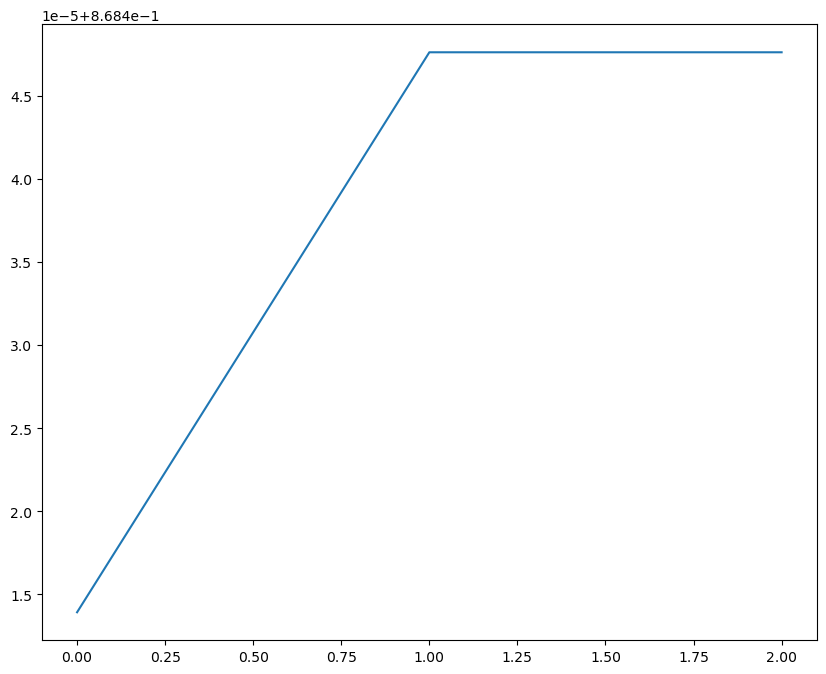

In [15]:
plt.figure(figsize=(10,8))
plt.plot(cvs1)
# 
plt.show();

In [13]:

estimators = [('normalise', StandardScaler()), 
              ('model', LogisticRegression(C=1,penalty='l1', solver='liblinear',random_state=42))]
pipe = Pipeline(estimators)


In [14]:

estimators_prime = [('normalise', StandardScaler()), 
              ('model', LogisticRegression(C=1,penalty='l1', solver='liblinear',random_state=42))]
pipe_prime = Pipeline(estimators_prime)

In [27]:

params = {
    'model__C': [0.1,1,10,1000],
    'model__random_state':[42],
    'normalise': [StandardScaler()]
    
}

grid_search = GridSearchCV(pipe, param_grid=params, verbose=3, n_jobs=2)

In [28]:
fittedgrid = grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END model__C=10, model__random_state=42, normalise=StandardScaler();, score=0.854 total time= 1.6min
[CV 2/5] END model__C=10, model__random_state=42, normalise=StandardScaler();, score=0.851 total time= 1.9min
[CV 3/5] END model__C=10, model__random_state=42, normalise=StandardScaler();, score=0.852 total time= 1.9min
[CV 4/5] END model__C=10, model__random_state=42, normalise=StandardScaler();, score=0.854 total time= 1.7min
[CV 1/5] END model__C=1000, model__random_state=42, normalise=StandardScaler();, score=0.854 total time= 1.7min
[CV 5/5] END model__C=10, model__random_state=42, normalise=StandardScaler();, score=0.851 total time= 1.7min
[CV 2/5] END model__C=1000, model__random_state=42, normalise=StandardScaler();, score=0.851 total time= 2.2min
[CV 3/5] END model__C=1000, model__random_state=42, normalise=StandardScaler();, score=0.852 total time= 2.2min
[CV 5/5] END model__C=1000, model__random_state=42, no

In [29]:
fittedgrid.best_estimator_

Pipeline(steps=[('normalise', StandardScaler()),
                ('model',
                 LogisticRegression(C=10, penalty='l1', random_state=42,
                                    solver='liblinear'))])

In [32]:

estimators = [('normalise', StandardScaler()), 
              ('model', LogisticRegression(C=10,penalty='l1', solver='liblinear',random_state=42))]
pipe_final = Pipeline(estimators)


In [33]:
estimators_prime = [('normalise', StandardScaler()), 
              ('model', LogisticRegression(C=10,penalty='l1', solver='liblinear',random_state=42))]
pipe_final_prime  = Pipeline(estimators_prime)

In [34]:
pipe_final.fit(X_train, y_train)


Pipeline(steps=[('normalise', StandardScaler()),
                ('model',
                 LogisticRegression(C=10, penalty='l1', random_state=42,
                                    solver='liblinear'))])

In [39]:
pipe_final_prime.fit(X_train_prime, y_train_prime)

Pipeline(steps=[('normalise', StandardScaler()),
                ('model',
                 LogisticRegression(C=10, penalty='l1', random_state=42,
                                    solver='liblinear'))])

In [40]:
log_clas = pipe_final[-1]
log_clas_prime = pipe_final_prime[-1]



In [41]:
log_clas

LogisticRegression(C=10, penalty='l1', random_state=42, solver='liblinear')

In [46]:
y_pred_train = pipe_final.predict(X_train_transformed)
y_pred_test = pipe_final.predict(X_test_transformed)

/Users/edo/anaconda3/envs/es_capstone/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/edo/anaconda3/envs/es_capstone/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [47]:
y_pred_train_prime = pipe_final_prime.predict(X_train_transformed_prime)
y_pred_test_prime = pipe_final_prime.predict(X_test_transformed_prime)


/Users/edo/anaconda3/envs/es_capstone/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/edo/anaconda3/envs/es_capstone/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [48]:
accuracy_score(y_train, y_pred_train),accuracy_score(y_test, y_pred_test)

(0.7216924287913512, 0.7239373632956715)

In [49]:
accuracy_score(y_train_prime, y_pred_train_prime),accuracy_score(y_test, y_pred_test_prime)

(0.8037013373604194, 0.789590270134719)

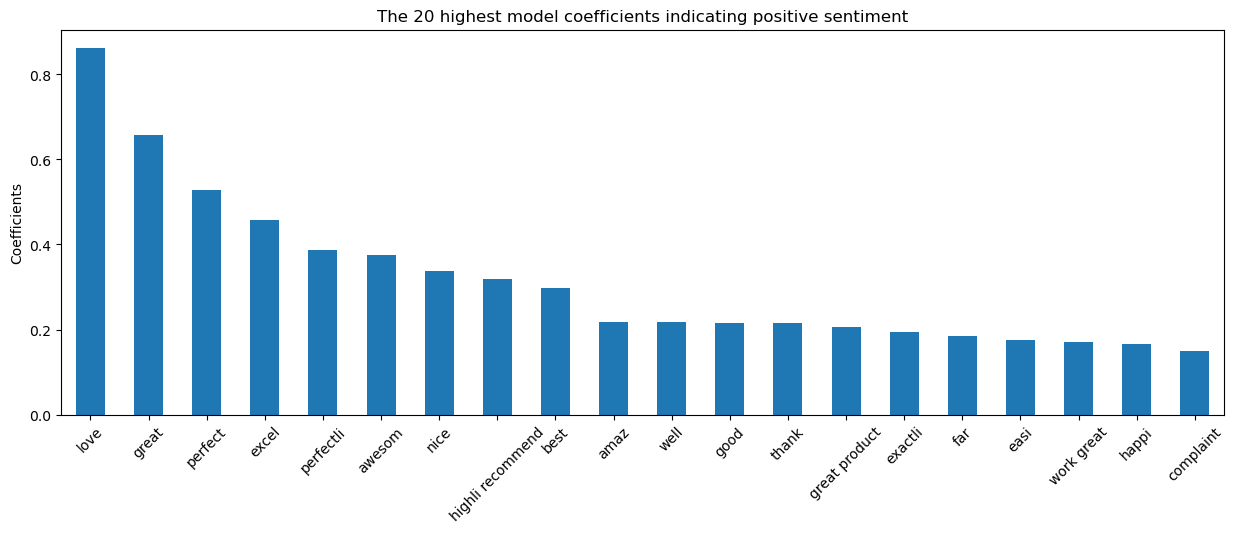

In [50]:
word_counts = pd.DataFrame(
    {"coefficients": log_clas.coef_[0]},
    index=X_train.columns
).sort_values("coefficients", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)

plt.title("The 20 highest model coefficients indicating positive sentiment")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

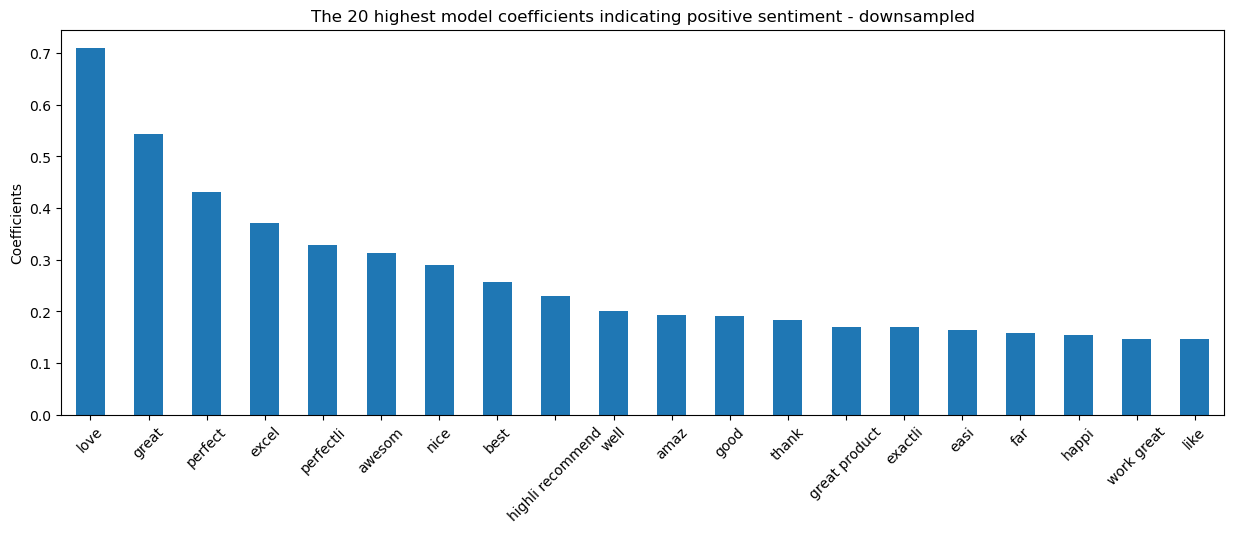

In [51]:
word_counts = pd.DataFrame(
    {"coefficients": log_clas_prime.coef_[0]},
    index=X_train_prime.columns
).sort_values("coefficients", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)

plt.title("The 20 highest model coefficients indicating positive sentiment - downsampled")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

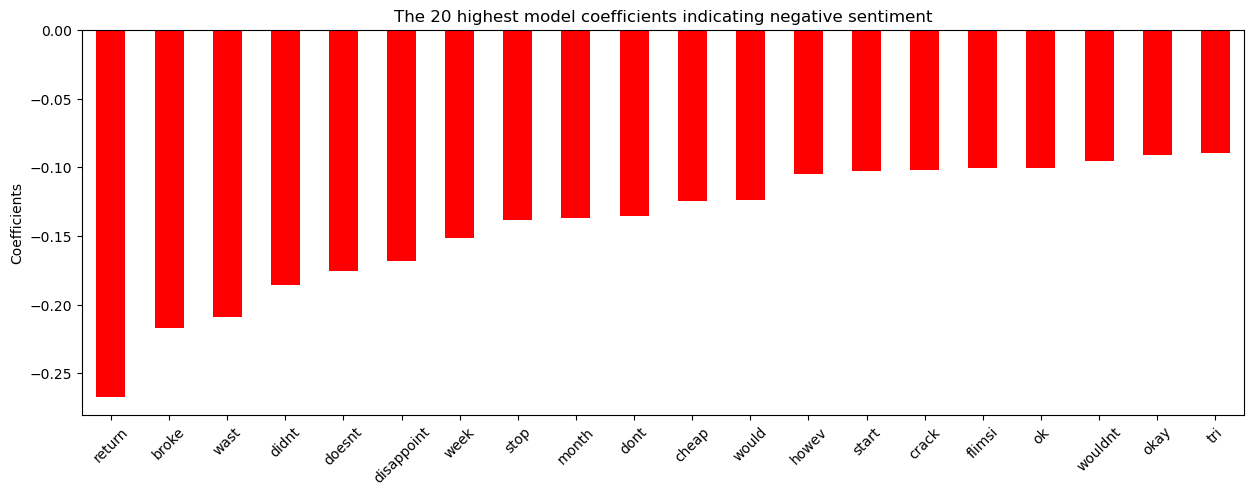

In [52]:
word_counts = pd.DataFrame(
    {"coefficients": log_clas.coef_[0]},
    index=X_train.columns
).sort_values("coefficients", ascending=True)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False, color='red')

plt.title("The 20 highest model coefficients indicating negative sentiment")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

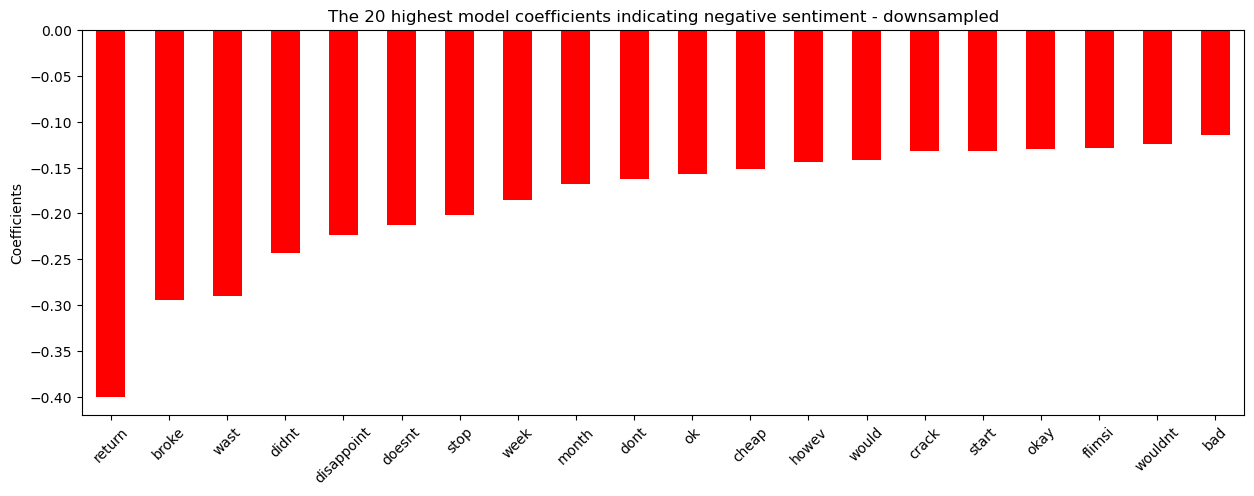

In [53]:
word_counts = pd.DataFrame(
    {"coefficients": log_clas_prime.coef_[0]},
    index=X_train_prime.columns
).sort_values("coefficients", ascending=True)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False, color='red')

plt.title("The 20 highest model coefficients indicating negative sentiment - downsampled")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

In [54]:

cm = confusion_matrix(y_test, y_pred_test, normalize="true")
cm_count = confusion_matrix(y_test, y_pred_test)

In [55]:
cm_prime = confusion_matrix(y_test, y_pred_test_prime, normalize="true")
cm_prime_count = confusion_matrix(y_test, y_pred_test_prime)

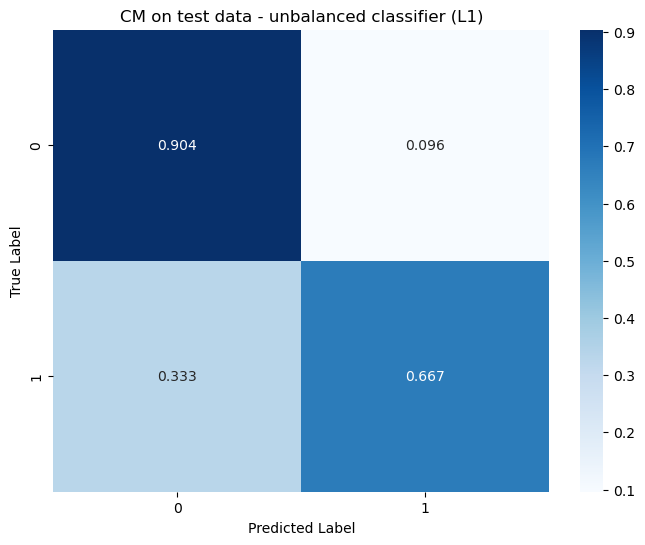

In [56]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt=".3f", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("CM on test data - unbalanced classifier (L1)")
plt.show()

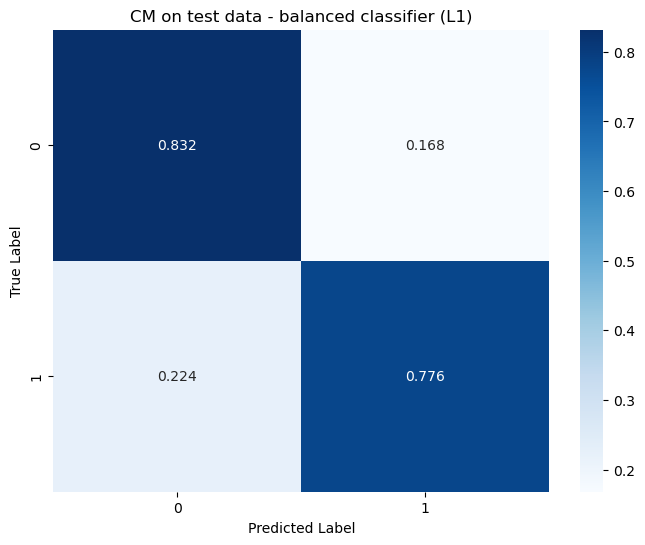

In [57]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_prime, annot=True, fmt=".3f", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("CM on test data - balanced classifier (L1)")
plt.show()

In [58]:
y_pred_baseline= log_clas.predict(scaler.transform(df[df.columns[4:]]))


In [59]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.46      0.90      0.61     34434
           1       0.96      0.67      0.79    109124

    accuracy                           0.72    143558
   macro avg       0.71      0.79      0.70    143558
weighted avg       0.84      0.72      0.74    143558



In [60]:
print(classification_report(y_test, y_pred_test_prime))

              precision    recall  f1-score   support

           0       0.54      0.83      0.65     34434
           1       0.94      0.78      0.85    109124

    accuracy                           0.79    143558
   macro avg       0.74      0.80      0.75    143558
weighted avg       0.84      0.79      0.80    143558



In [61]:
incorrect_guesses = df["binary"] != y_pred_baseline
incorrect_v = pd.Series(y_pred_baseline)[incorrect_guesses]
pd.concat([pd.Series(incorrect_v),df[incorrect_guesses]], axis=1)


,0,overall,reviewText,length,binary,10,abl,absolut,access,actual,...,worri,worth,would,would buy,would recommend,wouldnt,wrong,year,yet,your
2,1,3.0,"so the case came on time, i love the design. I...",257,0,0.0,0.0,0.0,0.0,0.195242,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.201246,0.0
16,1,2.0,I used this case for not even a week and the b...,118,0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.266645,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
58,0,4.0,The case is pretty and looks closely to the on...,434,1,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
61,1,3.0,When i recieved it the first time it was white...,296,0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
64,1,3.0,The idea of the design is a sweet idea but it ...,216,0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
717762,0,5.0,Didn't think I would like it because I'm use t...,132,1,0.0,0.0,0.0,0.0,0.295681,...,0.0,0.0,0.198844,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
717767,1,2.0,The good:\n- a good firm grip on my phone.\n- ...,308,0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.150004,0.252651,0.0,0.0,0.0,0.0,0.000000,0.0
717779,1,1.0,The glass screen was smashed when it arrived.,45,0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
717784,1,3.0,my sons likes it. For the price it isn't too bad,48,0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
